# Pytorch
Ejemplo de clasificador con Pytorch, comentado en español. 

El cuaderno de Jupyter se ha desarrollado con Visual Code y puedes encontrar el código en https://github.com/josegemez/pytorch_mnist 

Se ha desarrollado en python 3.10.4 

## Import
Con las primeras lineas vamos a importar los paquetes que básicos de Pytorch. 

In [1]:
import torch
import torchvision

## Variables Generales

In [2]:
batch_size_train = 128
batch_size_test = 128

## Transformaciones 

In [3]:
transforms=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])

## Dataset 

In [4]:
dataset_mnist = torchvision.datasets.MNIST('/files/', train=True, download=True, transform=transforms)                    

In [5]:
train_size = int(0.8 * len(dataset_mnist))
test_size = len(dataset_mnist) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_mnist, [train_size, test_size])

## Dataloader

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset,  batch_size=batch_size_train, shuffle=True,num_workers=1,pin_memory=True)

Vamos a ver que "pinta" tiene cada elemento del cargador

In [7]:
x, y = next(iter(train_loader)) #asignamos el primer batch a las variables x e y. La variable X contrendra las imagenes e y contrendra las etiquetas

x es un batch, por lo que la primera dimensión coincidira con el batch size 

In [8]:
from matplotlib.pyplot import imshow

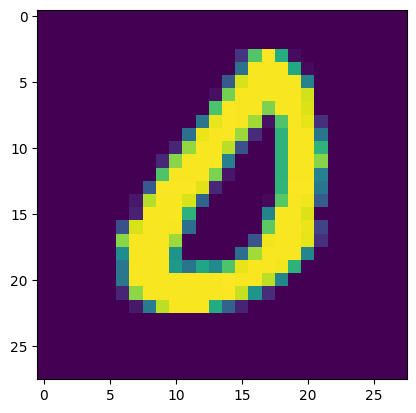

In [9]:
imshow(x[0].view(28,28).numpy()); # transformamos el primer elemento del batch una matriz de numpy y mostramos con matplotlib

In [10]:
y

tensor([0, 1, 2, 5, 0, 2, 3, 6, 6, 4, 4, 7, 4, 7, 8, 4, 2, 6, 3, 6, 9, 8, 9, 3,
        1, 3, 7, 3, 3, 7, 5, 1, 2, 9, 7, 4, 8, 5, 5, 2, 4, 1, 4, 2, 1, 8, 3, 1,
        1, 4, 8, 9, 1, 3, 3, 0, 1, 4, 5, 7, 9, 6, 4, 4, 7, 5, 7, 9, 9, 0, 3, 4,
        1, 1, 6, 3, 8, 9, 4, 1, 6, 0, 3, 8, 1, 7, 4, 2, 6, 4, 6, 3, 3, 4, 3, 1,
        0, 2, 6, 0, 1, 5, 8, 3, 6, 1, 5, 5, 6, 1, 9, 9, 6, 8, 1, 3, 3, 5, 1, 5,
        9, 8, 0, 3, 5, 2, 5, 9])

## Dataset Test

In [11]:
test_loader = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size_test, shuffle=True, num_workers=1,pin_memory=True)              

Ya tenemos los datos preparados, ahora vamos a crear la red

In [12]:
learning_rate   =   0.01
momentum   =   0.5
n_epochs = 3


In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np

## MLP

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28,40) #capa "fuly connect" entrada 28*28 (tamaño de la imagen) 50 neuronas
        self.fc1_drop = nn.Dropout(0.2) #dropout (regularizacion) 20% 
        self.fc2 = nn.Linear(40, 20) #capa fully connect 50 neuronas 
        self.fc2_drop = nn.Dropout(0.2) #dropout (regularizacion) 20%
        self.fc3 = nn.Linear(20, 10) #capa de salida numero de salida igual al de etiquetas

    def forward(self, x):
        x = x.view(-1, 28*28) #cambia la forma del tensor, -1 para quitar la dimensiones anteriores y dejarlo todo en una vector de 256 elementos
        x = F.relu(self.fc1(x)) #capa fully connect y luego activacion relu
        x = self.fc1_drop(x) #dropout (regularizacion)
        x = F.relu(self.fc2(x)) #capa fully connect y luego activacion relu
        x = self.fc2_drop(x) #dropout (regularizacion)
        return F.log_softmax(self.fc3(x), dim=1) #soft max (estimacion estadistica 0-1 de la probabildad de que sea de un etiqueta u otra)

## Convolutional

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [15]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')
device

device(type='cuda')

In [16]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
criterion =  nn.CrossEntropyLoss().to(device)


In [17]:
model

Net(
  (fc1): Linear(in_features=784, out_features=40, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=40, out_features=20, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
)

In [18]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

In [24]:
for epoch in range(n_epochs):
  epoch_train_loss = []
  epoch_train_acc = []
  epoch_test_loss = []
  epoch_test_acc = []
  running_loss = 0.
  model.train() #modelo en modo entranamiento
   #perdida de la primera epoca
  with tqdm(train_loader, unit='batch') as tepoch: #tqdm para ver la barra de progreso por batch
    for data, target in tepoch: #en cada batch data la imagen de 28x28 y target la prediccion
      model.train()
      tepoch.set_description(f'Epoch {epoch}') #texto al final de la barra de progreso
      data, target = data.to(device=device, non_blocking=True), target.to(device=device, non_blocking=True).long() #se pasan lo datos y las etiquetas al "device"
      optimizer.zero_grad() #se inicializan los gradientes
      output = model(data) #se realiza la predicción propagación haciea adelante
      loss = F.nll_loss(output, target) #se calcula la funcion de perdida entre los valores predichos (output) y los valores reales (target)
      pred = output.data.max(1, keepdim=True)[1] #valores predichos
      correct = pred.eq(target.data.view_as(pred)).sum()
      accuracy = correct.item()/batch_size_train
      epoch_train_acc.append(accuracy)
      epoch_train_loss.append(loss.cpu().item()) #se guardan el valor de la perdida
      loss.backward() #se realiza la retropropagación 
      optimizer.step() #se realiza un paso adelante con el learning rate y el gradiente calculado
      running_loss += loss.item()
      i, datum = next(enumerate(test_loader))
      data, target = datum
      data, target = data.to(device=device, non_blocking=True), target.to(device=device, non_blocking=True).long() #se pasan lo datos y las etiquetas al "device"
      output = model(data) #se realiza la predicción propagación haciea adelante
      t_loss = F.nll_loss(output, target) #se calcula la funcion de perdida entre los valores predichos (output) y los valores reales (target)    
      pred = output.data.max(1, keepdim=True)[1] #valores predichos
      correct = pred.eq(target.data.view_as(pred)).sum()    
      test_accuracy = correct.item()/batch_size_test
      epoch_test_acc.append(test_accuracy)
      epoch_test_loss.append(t_loss.cpu().item()) #se guardan el valor de la perdida
      train_loss.append(np.mean(epoch_train_loss))
      test_loss.append(np.mean(epoch_test_loss))
      train_acc.append(np.mean(epoch_train_acc))
      test_acc.append(np.mean(epoch_test_acc))
  scheduler.step() #se realiza un paso para cambiar el learning rate
  print(f'Epoch {epoch}: Train loss {np.mean(epoch_train_loss)} Test loss {np.mean(epoch_test_loss)} Train accuracy {np.mean(epoch_train_acc)} Test accuracy {np.mean(epoch_test_acc)}')


Epoch 0:  10%|▉         | 36/375 [01:19<12:54,  2.28s/batch]

In [21]:
running_loss

206.7832682132721

In [ ]:
len(epoch_train_loss)

In [ ]:
len(epoch_test_loss)

In [ ]:
epoch_test_loss

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_losses(train_loss, test_loss, save_to_file=None):
    fig = plt.figure()
    epochs = len(train_loss)
    plt.plot(range(epochs), train_loss, 'bo', label='Training loss')
    plt.plot(range(epochs), test_loss,  label='Test loss', c="red")
    plt.title('Training and test loss')
    plt.legend()
    plt.ylim([0, 3])
    if save_to_file:
        fig.savefig()


def plot_accuracies(train_acc, test_acc, save_to_file=None):
    fig = plt.figure()
    epochs = len(train_acc)
    plt.plot(range(epochs), train_acc, 'bo', label='Training accuracy')
    plt.plot(range(epochs), test_acc,  label='Test accuracy', c="red")
    plt.title('Training and test accuracy')
    plt.legend()
    plt.ylim([0, 1])
    if save_to_file:
        fig.savefig(save_to_file)

In [ ]:
plot_losses(train_loss, test_loss, save_to_file=None)
plot_accuracies(train_acc, test_acc, save_to_file=None)